In [16]:
## Some imports might be redundant because the code was split up into pieces
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from operator import itemgetter
from itertools import groupby
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
# Set the plot size
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
def print_scores(y_predict, y_true):
    TP, FP, FN, TN = 0, 0, 0, 0
    for i in range(len(y_predict)):
        if y_true[i]==1 and y_predict[i]==1:
            TP += 1
        if y_true[i]==0 and y_predict[i]==1:
            FP += 1
        if y_true[i]==1 and y_predict[i]==0:
            FN += 1
        if y_true[i]==0 and y_predict[i]==0:
            TN += 1
    print('TP: '+ str(TP))
    print('FP: '+ str(FP))
    print('FN: '+ str(FN))
    print('TN: '+ str(TN))

In [4]:
# Read the data in pandas
data = pd.read_csv("data_for_student_case.csv")
data['bookingdate'] =  pd.to_datetime(data['bookingdate'])
data['creationdate'] =  pd.to_datetime(data['creationdate'])

# Delete the refused transactions (but keep them for later use maybe)

refused_data = data.loc[data['simple_journal'] == "Refused", :]
dataset = data.loc[data['simple_journal'] != "Refused", :].copy()
dataset['bool_fraud'] = (dataset['simple_journal'] == "Chargeback").copy().astype(int)
dataset['bool_valid'] = (dataset['simple_journal'] == "Settled").copy().astype(int)

# Do some preprocessing for the ML algorithms
finalset = dataset.copy()
finalset['mail_id'] = finalset['mail_id'].str.replace('email','')
finalset['ip_id'] = finalset['ip_id'].str.replace('ip','')
finalset['card_id'] = finalset['card_id'].str.replace('card','')


## Transform the data into onehot vectors
targets_for_onehot = ['issuercountrycode', 'txvariantcode','currencycode', 'shoppercountrycode', 'shopperinteraction', 'cardverificationcodesupplied', 'cvcresponsecode']

new_df = pd.DataFrame([])

for target in targets_for_onehot:
    temp = pd.get_dummies(finalset[target])
    new_df = pd.concat([new_df, temp],axis=1)
    
new_df = pd.concat([new_df, finalset[['mail_id','ip_id','card_id','bin','amount']]], axis=1)
new_df = new_df.fillna(0)

## Get the features and labels
x = new_df.values
x[x=="NA"] = 0
x = x.astype(float)
y = finalset['bool_fraud'].values

In [5]:
## Get the necessary library
!pip3 install imblearn

In [6]:
from imblearn.over_sampling import SMOTE

## Create a SMOTE object
sm = SMOTE()

In [7]:
def train_and_plot_SMOTE(clf, x, y, title):    
    ## Make a split on the train/test set
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1)
    x_train_smoted, y_train_smoted = sm.fit_resample(x_train, y_train)
    
    trained_clf = clf.fit(x_train, y_train)
    predictions = trained_clf.predict_proba(x_test)

    trained_clf_smoted = clf.fit(x_train_smoted, y_train_smoted)
    predictions_smoted = trained_clf_smoted.predict_proba(x_test)


    print("ROC AUC score UNSMOTEd: " + str(roc_auc_score(y_test, predictions[:,1])))
    fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
    print("ROC AUC score SMOTEd: " + str(roc_auc_score(y_test, predictions_smoted[:,1])))
    fpr_smoted, tpr_smoted, _ = roc_curve(y_test, predictions_smoted[:,1])

    plt.clf()
    plt.plot(fpr, tpr, label='UNSMOTEd')
    plt.plot(fpr_smoted, tpr_smoted, label='SMOTEd')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve ' + title)
    plt.legend()
    plt.show()

In [ ]:
# Run the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100)
train_and_plot_SMOTE(clf, x, y, "Random Forest")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC AUC score UNSMOTEd: 0.8144693097166589
ROC AUC score SMOTEd: 0.8855574459477971


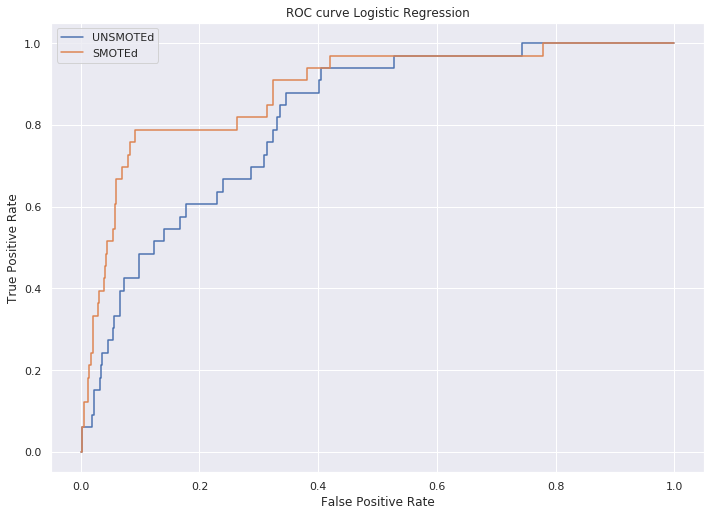

In [9]:
# Run the LogisticRegression
clf = LogisticRegression()
train_and_plot_SMOTE(clf, x, y, "Logistic Regression")

ROC AUC score UNSMOTEd: 0.574366125760649
ROC AUC score SMOTEd: 0.5486688640973632


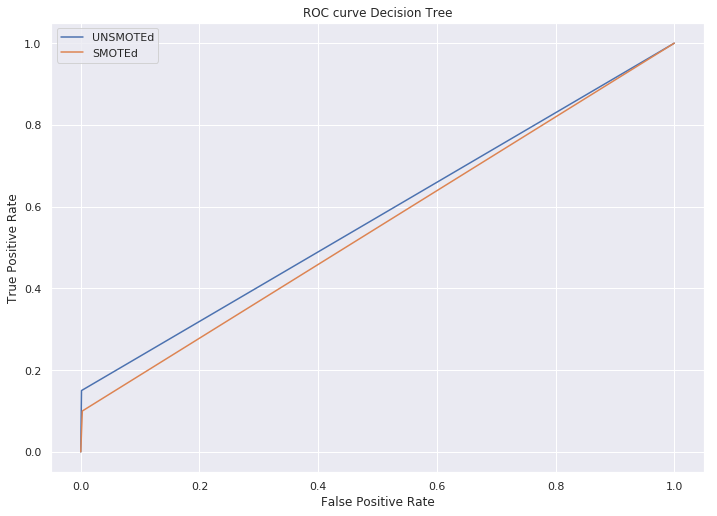

In [10]:
# Run the DecisionTreeClassifier
clf = DecisionTreeClassifier()
train_and_plot_SMOTE(clf, x, y, "Decision Tree")

ROC AUC score UNSMOTEd: 0.957064718943837
ROC AUC score SMOTEd: 0.9498097832645476


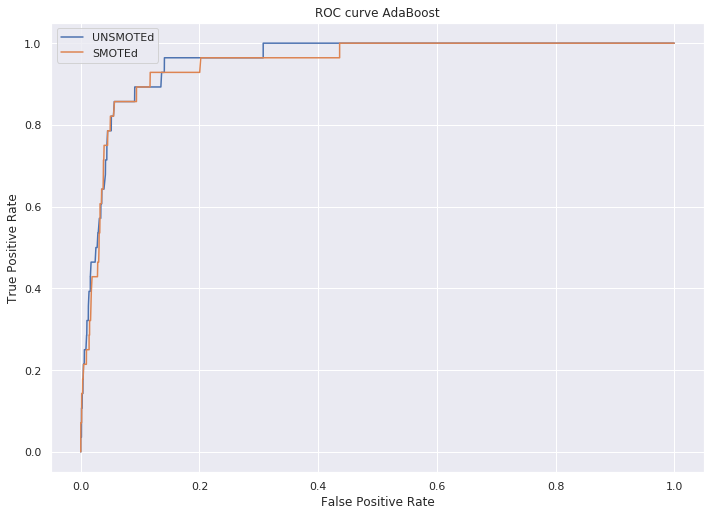

In [11]:
# Run the AdaBoost classifier
clf = AdaBoostClassifier()
train_and_plot_SMOTE(clf, x, y, "AdaBoost")

ROC AUC score UNSMOTEd: 0.5250854411958013
ROC AUC score SMOTEd: 0.5995425140367678


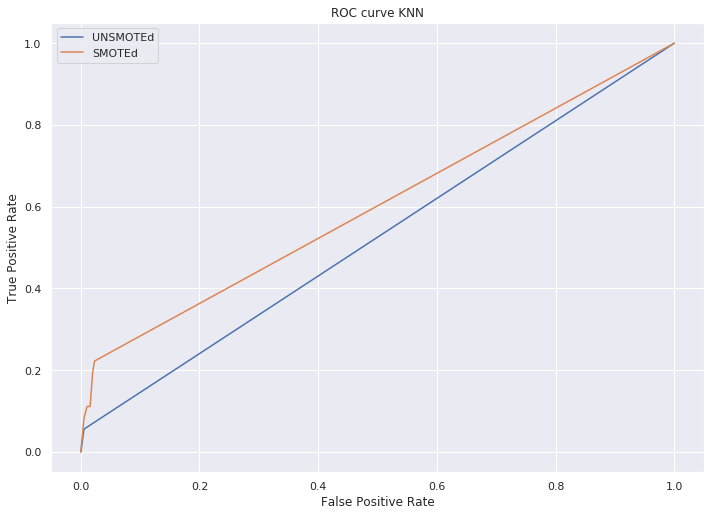

In [12]:
# Run the KNN classifier
clf = KNeighborsClassifier()
train_and_plot_SMOTE(clf, x, y, "KNN")

In [ ]:
# Run the MLPClassifier
clf = MLPClassifier()
train_and_plot_SMOTE(clf, x, y, "Multi-Layer Perceptron")